In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gp import *
from data_loader import data_loader
import time

In [2]:
filename = 'trajectory.pkl'
compute_reduction = 50
n_training_samples = 100

d_loader = data_loader(filename, compute_reduction, n_training_samples)               

v_display = d_loader.get_z(training=False)[:,7:10]
y_display = d_loader.get_y(training=False)
a_validation = d_loader.get_a_validation()

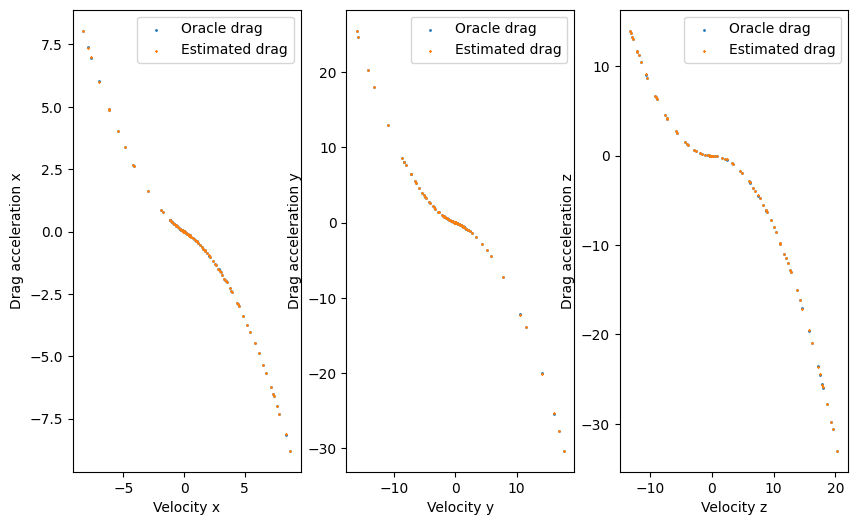

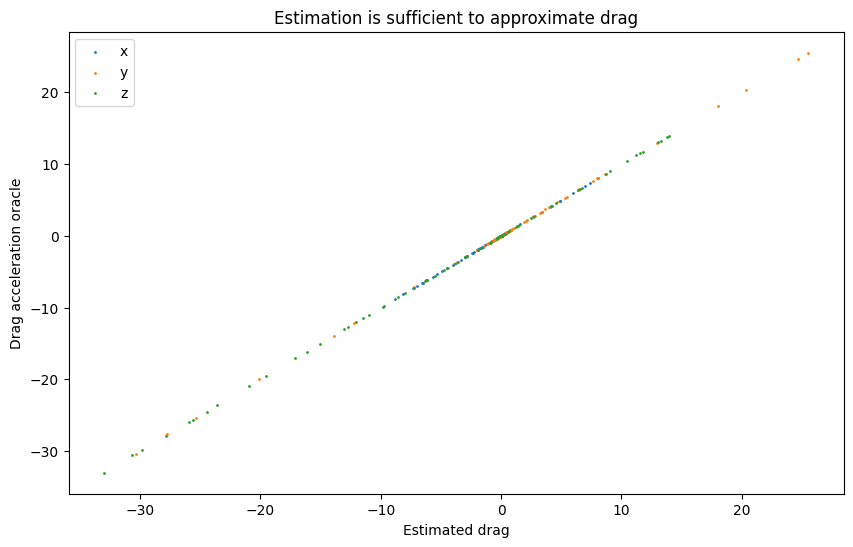

In [3]:
plt.figure(figsize=(10, 6), dpi=100)
plt.subplot(131)
plt.scatter(v_display[:,0], a_validation[:,0],s=1)
plt.scatter(v_display[:,0], y_display[:,0], marker='x',s=1)
plt.xlabel('Velocity x')
plt.ylabel('Drag acceleration x')
plt.legend(('Oracle drag', 'Estimated drag'))
plt.subplot(132)
plt.scatter(v_display[:,1], a_validation[:,1],s=1)
plt.scatter(v_display[:,1], y_display[:,1], marker='x',s=1)
plt.xlabel('Velocity y')
plt.ylabel('Drag acceleration y')
plt.legend(('Oracle drag', 'Estimated drag'))
plt.subplot(133)
plt.scatter(v_display[:,2], a_validation[:,2],s=1)
plt.scatter(v_display[:,2], y_display[:,2], marker='x',s=1)
plt.xlabel('Velocity z')
plt.ylabel('Drag acceleration z')
plt.legend(('Oracle drag', 'Estimated drag'))



plt.figure(figsize=(10, 6), dpi=100)
plt.scatter(y_display[:,0], a_validation[:,0],s=1)
plt.scatter(y_display[:,1], a_validation[:,1],s=1)
plt.scatter(y_display[:,2], a_validation[:,2],s=1)
plt.xlabel('Estimated drag')
plt.ylabel('Drag acceleration oracle')
plt.title('Estimation is sufficient to approximate drag')
plt.legend(('x', 'y', 'z'))

In [4]:

# z = d_loader.get_z(training=False)
# y = d_loader.get_y(training=False)


# z_train = d_loader.get_z(training=True)
# y_train = d_loader.get_y(training=True)

# # x velocity
# z_x_train = z_train[:,7].reshape(-1,1)
# z_x = z[:,7].reshape(-1,1)

# y_x_train = y_train[:,0].reshape(-1,1)
# y_x = y[:,0].reshape(-1,1)

# # y velocity
# z_y_train = z_train[:,8].reshape(-1,1)
# z_y = z[:,8].reshape(-1,1)

# y_y_train = y_train[:,1].reshape(-1,1)
# y_y = y[:,1].reshape(-1,1)

# # z velocity
# z_z_train = z_train[:,9].reshape(-1,1)
# z_z = z[:,9].reshape(-1,1)

# y_z_train = y_train[:,2].reshape(-1,1)
# y_z = y[:,2].reshape(-1,1)

In [5]:
def one_dim_GPR(dim):
    
    z = d_loader.get_z(training=False)
    y = d_loader.get_y(training=False)


    z_train = d_loader.get_z(training=True)
    y_train = d_loader.get_y(training=True)


    if dim == 'x':
        # x velocity
        z_train = z_train[:,7].reshape(-1,1)
        z = z[:,7].reshape(-1,1)

        y_train = y_train[:,0].reshape(-1,1)
        y = y[:,0].reshape(-1,1)
        
    if dim == 'y':
        # y velocity
        z_train = z_train[:,8].reshape(-1,1)
        z = z[:,8].reshape(-1,1)

        y_train = y_train[:,1].reshape(-1,1)
        y = y[:,1].reshape(-1,1)
        
    if dim == 'z':
        # z velocity
        z_train = z_train[:,9].reshape(-1,1)
        z = z[:,9].reshape(-1,1)

        y_train = y_train[:,2].reshape(-1,1)
        y = y[:,2].reshape(-1,1)
    
    theta0 = [1,1,1] # Kernel variables
    x_query = np.arange(-20,20,0.05).reshape(-1,1)

    model = GPR(z_train, y_train, covariance_function=RBF, theta=theta0)
    # Before ML optimization
    mean_b, std_b = model.predict(x_query, std=True)

    # Calculate the RMS over all samples
    mean_test_before = model.predict(z, std=False)
    rms_before = np.sqrt(np.mean((y - mean_test_before)**2))

    # ML optimization
    model.maximize_likelyhood()

    # After optimization
    mean_a, std_a = model.predict(x_query, std=True)

    # Calculate the RMS over all samples
    mean_test_after = model.predict(z, std=False)
    rms_after = np.sqrt(np.mean((y - mean_test_after)**2))

    print(f'RMS before = {rms_before}')
    print(f'RMS after = {rms_after}')
    
    plt.figure(figsize=(10,6), dpi=100)
    plt.subplot(1,2,1)
    plt.plot(x_query, mean_b)
    plt.scatter(z, y, s=1, c='g')
    plt.plot(z_train, y_train, 'x')
    plt.fill_between(x_query.reshape(-1), mean_b.reshape(-1) - std_b, mean_b.reshape(-1) + std_b,
                     color='gray', alpha=0.2)
    plt.xlabel('Velocity in x [ms-1]')
    plt.ylabel('Acceleration error in x [ms-2]')
    plt.title(f'GP Before ML optimization, rms = {rms_before:.2f}')
    plt.legend(('GP interpolation', 'Measured samples', 'Training samples'))


    plt.subplot(1,2,2)
    plt.plot(x_query, mean_a)
    plt.scatter(z, y, s=1, c='g')
    plt.plot(z_train, y_train, 'x')
    plt.fill_between(x_query.reshape(-1), mean_a.reshape(-1) - std_a, mean_a.reshape(-1) + std_a,
                     color='gray', alpha=0.2)
    plt.xlabel('Velocity in x [ms-1]')
    plt.ylabel('Acceleration error in x [ms-2]')
    plt.title(f'GP Before ML optimization, rms = {rms_after:.2f}')
    plt.legend(('GP interpolation', 'Measured samples', 'Training samples'))

Size of feature training data = (100, 1)
Size of output training data = (100, 1)


/home/ja/Projects/MPC_drone/mpc_quad/gp/gp.py:128: RuntimeWarning: invalid value encountered in multiply
  cov_mat = np.empty((x1.shape[0], x2.shape[0]))*np.NaN


Maximizing the likelyhood function for GP
Hyperparameters before optimization = [1, 1, 1]
Size of feature training data = (100, 1)
Size of output training data = (100, 1)
Optimization done
Hyperparameters after optimization = [8.3278171  9.95027285 0.01      ]
RMS before = 0.3783985686722012
RMS after = 0.02599008784845119


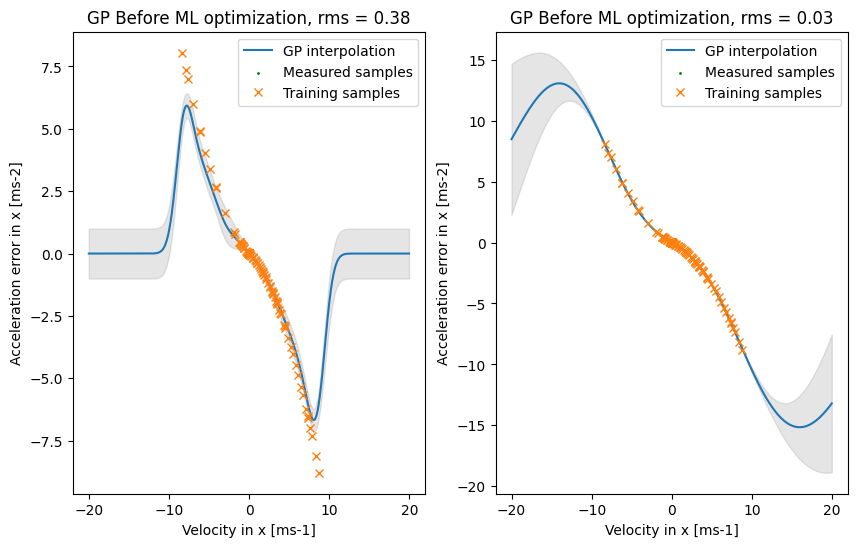

In [6]:
one_dim_GPR('x')

Size of feature training data = (100, 1)
Size of output training data = (100, 1)
Maximizing the likelyhood function for GP
Hyperparameters before optimization = [1, 1, 1]
Size of feature training data = (100, 1)
Size of output training data = (100, 1)
Optimization done
Hyperparameters after optimization = [8.14033509e+00 2.06685841e+01 1.00000000e-02]
RMS before = 1.8117161289976367
RMS after = 0.029843183473070977


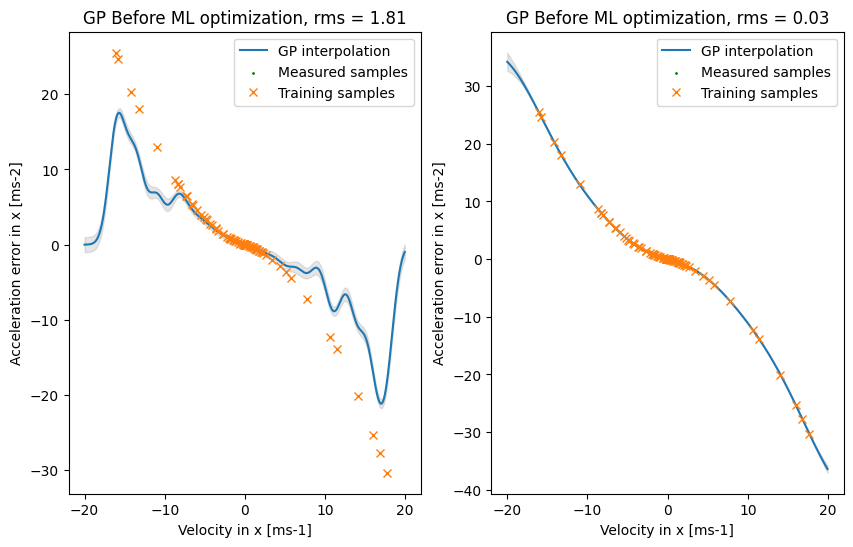

In [7]:
one_dim_GPR('y')

In [ ]:
one_dim_GPR('z')

Size of feature training data = (100, 1)
Size of output training data = (100, 1)
